In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
# from importlib import reload
# import vehicles
# import game
# import agents
# import evaluation
# import models
# reload(vehicles)
# reload(game)
# reload(agents)
# reload(evaluation)
# reload(models)
# import torch

In [3]:
import random
random.seed(42)
import torch
torch.manual_seed(42)

In [4]:
#@title Vehicle provider
from vehicles import CompromiseState, Vehicle, VehicleProvider, Vulnerability, JsonVehicleProvider

class RubbishVehicleProvider(VehicleProvider):
    def __init__(self) -> None:
        self.max_vulns=1

    def next(self) -> Vehicle:
        return Vehicle(
            10,
            [
                Vulnerability(0.5,2,CompromiseState.NOT_COMPROMISED),
            ]
        )

provider = "default" #@param ["default", "rubbish"]
if provider == "default":
  vehicle_provider = JsonVehicleProvider("../subgame/python/solutions.json")
elif provider == "rubbish":
  vehicle_provider=RubbishVehicleProvider()
else:
  raise ValueError("unknown provider chosen")

In [5]:
#@title Game config
from game import GameConfig

game_config=GameConfig(
    max_vehicles=30,
    cycle_every=1,
    cycle_allow_platoon=False,
    cycle_num=10
)

In [11]:
#@title Attacker agent
from agents import PassiveAgent, BasicAttackerAgent

attacker_ = "humanish" #@param ["passive", "humanish"]
if attacker_ == "passive":
  attacker = PassiveAgent()
elif attacker_ == "humanish":
  attacker = BasicAttackerAgent(1)
else:
  raise ValueError("unknown attacker chosen")

In [7]:
#@title Defender agent
from agents import WolpertingerDefenderAgent
from models import StateShapeData

load_checkpoint = False #@param {type:"boolean"}
checkpoint = 1 #@param {type:"integer"}

defender=WolpertingerDefenderAgent(
    state_shape_data=StateShapeData(
        num_vehicles=game_config.max_vehicles,
        num_vehicle_features=Vehicle.get_shape()[0],
        num_vulns=vehicle_provider.max_vulns,
        num_vuln_features=Vulnerability.get_shape()[0]
    ),
    learning_rate=0.001,
    num_proposals=3,
)

if load_checkpoint:
  defender.load(dir="checkpoints", prefix="2022-10-10 0157-57 479857")

c:\Users\TeamD\.conda\envs\subgame\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [12]:
#@title Trainer
from training import WolpertingerDefenderAgentTrainer, WolpertingerDefenderAgentTrainerConfig
stats_history = []
trainer = WolpertingerDefenderAgentTrainer(WolpertingerDefenderAgentTrainerConfig(
    game_config=game_config,
    vehicle_provider=vehicle_provider,
    attacker_agent=attacker,
    defender_agent=defender,
    metrics_callback=stats_history.append,
    checkpoint_interval=100,

    batch_size=2000,
    train_steps=50,
    train_interval=1,
    warmup_steps=4000,
    max_steps_per_episode=25,
    update_policy_interval=10,
    policy_update_type="soft",
))
latest_stats = trainer.train()

Warming up...


  0%|          | 0/4000 [00:00<?, ?it/s]

Warmup complete~!
2022-10-11 2008-18 702133 episode 1 step 4000 optimizing loss=113223.4062 diff={max=344.7593, min=1.7616, mean=333.9138} policy_loss=-13.9147 policy updated! 
2022-10-11 2008-20 825134 episode 1 step 4001 optimizing loss=105387.0469 diff={max=333.9107, min=1.9350, mean=321.7070} policy_loss=-4.5319 
2022-10-11 2008-22 904135 episode 1 step 4002 optimizing loss=99616.4062 diff={max=324.5276, min=1.4416, mean=312.6629} policy_loss=0.3087 
2022-10-11 2008-25 003134 episode 1 step 4003 optimizing loss=96733.6797 diff={max=319.6872, min=14.6932, mean=308.3043} policy_loss=0.6722 
2022-10-11 2008-27 110135 episode 1 step 4004 optimizing loss=95706.2578 diff={max=319.3238, min=0.3256, mean=306.0067} policy_loss=1.3699 
2022-10-11 2008-29 258180 episode 1 step 4005 optimizing loss=95526.7812 diff={max=318.6260, min=3.3676, mean=305.7164} policy_loss=2.6847 
2022-10-11 2008-31 349181 episode 1 step 4006 optimizing loss=94934.1797 diff={max=317.3112, min=1.6768, mean=305.0653} 

In [10]:
from memory import TransitionTensorBatch

batch = TransitionTensorBatch.cat(trainer.memory.sample(10))
batch.state.vehicles.std(dim=1)
batch.state.vulnerabilities.std(dim=1)
batch.reward

proto_actions = defender.actor(batch.state)
print("action.members", proto_actions.members.sum(dim=0))
q_values = defender.critic(batch.state, proto_actions)
print("q_pred", q_values)
print("batch.reward", batch.reward)
print("pred reward err", q_values - batch.reward)

action.members tensor([[10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
         10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
         10., 10.]], grad_fn=<SumBackward1>)
q_pred tensor([30.8460, 30.8460, 30.8460, 30.8460, 30.8460, 30.8460, 30.8460, 30.8460,
        30.8460, 30.8460], grad_fn=<ReshapeAliasBackward0>)
batch.reward tensor([30., 30., 30., 30., 30., 30., 30., 30., 30., 30.])
pred reward err tensor([0.8460, 0.8460, 0.8460, 0.8460, 0.8460, 0.8460, 0.8460, 0.8460, 0.8460,
        0.8460], grad_fn=<SubBackward0>)


In [13]:
#@title Save checkpoint
from utils import get_prefix

prefix = get_prefix()
defender.save(dir="checkpoints", prefix=prefix)
print(prefix)

2022-10-11 2013-30 121292


AttributeError: 'EpisodeMetricsEntry' object has no attribute 'optim'

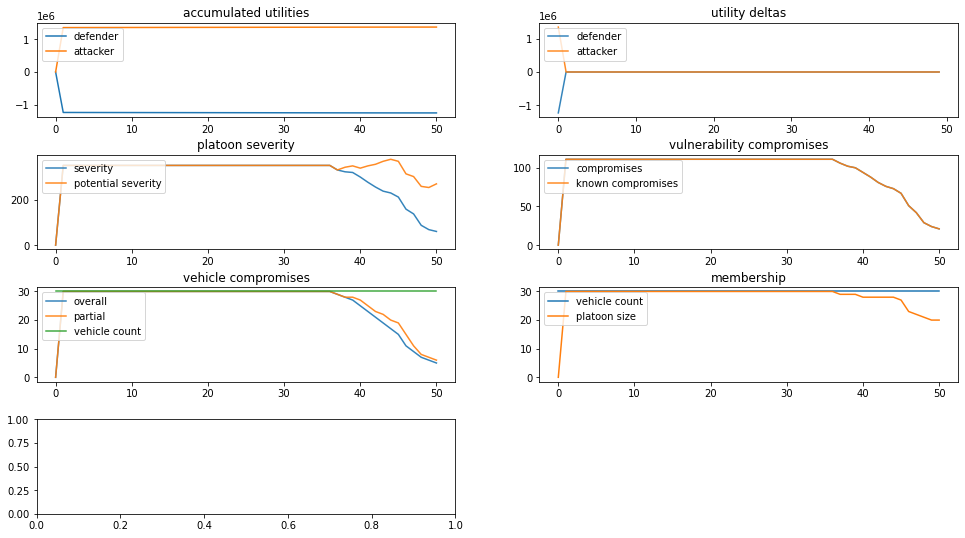

In [14]:
stats_history[0].plot()
# todo: enable attacker
# todo: enable normal vehicle provider
# todo: parameterize epsilon threshold

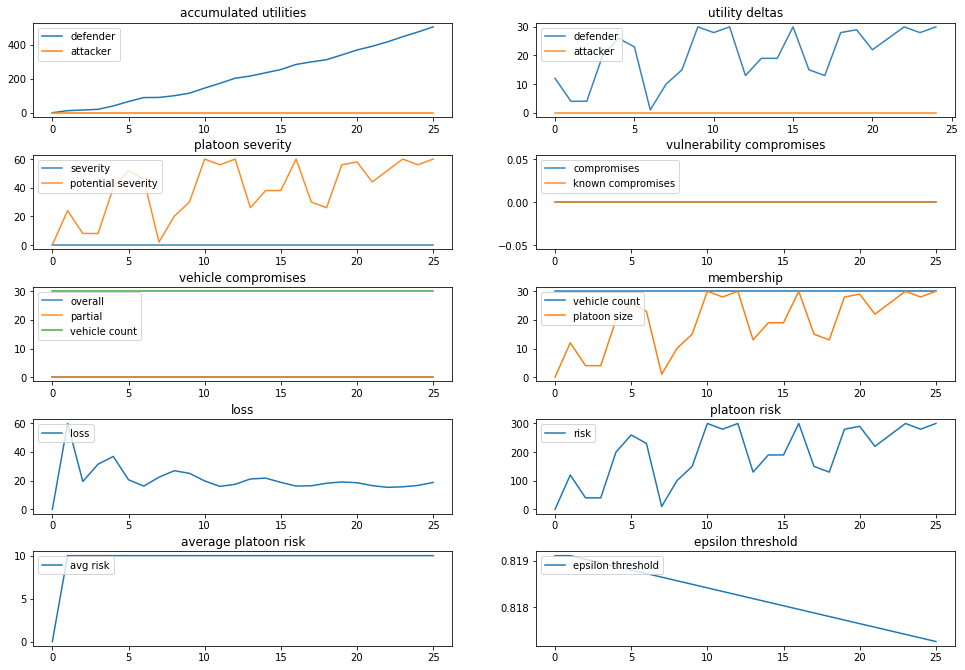

In [ ]:
stats_history[-1].plot()